In [ ]:
#| code-fold: true
#| code-summary: "Show pip installs"
!pip install transformers -Uqq
!pip install accelerate -qq
!pip install torch==2.2.2 -qq
!pip install datasets~=2.16.1 -qq
!pip install scikit-learn==1.2 -qq

In [2]:
#| code-fold: true
#| code-summary: "Show imports and setup"
import sklearn
import transformers
import torch
import datasets

assert sklearn.__version__ == '1.2.0'
assert transformers.__version__ == '4.44.2'
assert torch.__version__ == '2.2.2+cu121'
assert datasets.__version__ == '2.16.1'

In [3]:
from datasets import load_dataset, Dataset
import pandas as pd, numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import random

In [ ]:
#| code-fold: true
#| code-summary: "Show setup"
from transformers import AutoModelForCausalLM, AutoTokenizer
device = "cuda" # the device to load the model onto

model = AutoModelForCausalLM.from_pretrained(
    "Qwen/Qwen2-1.5B-Instruct",
    torch_dtype="auto",
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-1.5B-Instruct")

In [ ]:
#| code-fold: true
#| code-summary: "Show setup"
# load dataset
dataset = load_dataset(
    "financial_phrasebank", "sentences_allagree", 
    split="train"  # note that the dataset does not have a default test split
)

# create a new column with the numeric label verbalised as label_text (e.g. "positive" instead of "0")
label_map = {i: label_text for i, label_text in enumerate(dataset.features["label"].names)}

def add_label_text(example):
    example["label_text"] = label_map[example["label"]]
    return example

dataset = dataset.map(add_label_text)

print(dataset)

In [6]:
#| code-fold: true
#| code-summary: "Show `generate_response` function"
def generate_response(prompt):
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    model_inputs = tokenizer([text], return_tensors="pt").to(device)

    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=2
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response

In [7]:
def add_prompt(item, prompt):
        item['prompt'] = prompt.format(text=item['sentence'])
        return item
    
def generate_responses(dataset, prompt):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})
    print(dataset[0]['prompt'])
    
    for row in dataset:
        messages = [
            {"role": "user", "content": row['prompt']}
        ]
        
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        model_inputs = tokenizer([text], return_tensors="pt").to(device)

        generated_ids = model.generate(
            model_inputs.input_ids,
            max_new_tokens=2
        )
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].strip().lower()
        responses.append(response)
        
    # calculate accuracy
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
    df['lm_match'] = df['label_text'] == df['responses']
    acc = df.lm_match.mean()
    
    return df, acc

In [8]:
#| code-fold: true
#| code-summary: "Show `make_cm` function"
def make_cm(df):
    """Create confusion matrix for true vs predicted sentiment classes"""
    
    cm = confusion_matrix(y_true=df['label_text'], y_pred=df['responses'], labels=['negative', 'neutral', 'positive', 'other'])
    disp = ConfusionMatrixDisplay(cm, display_labels=['negative', 'neutral', 'positive', 'other'])
    
    # I chose 8x8 so it fits on one screen but still is large
    fig, ax = plt.subplots(figsize=(8,8))
    disp.plot(ax=ax,text_kw={'fontsize': 16}, cmap='Blues', colorbar=False);
    
    # change label font size without changing label text
    ax.xaxis.label.set_fontsize(18)
    ax.yaxis.label.set_fontsize(18)
    
    # make tick labels larger
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)

In [9]:
#| code-fold: true
#| code-summary: "Show `ds_subset` function"
def ds_subset(dataset, exclude_idxs, columns=[0, 1, 2]):
    idxs = list(range(len(dataset)))
    idxs = [x for x in idxs if x not in exclude_idxs]
    ddf = dataset.to_pandas()
    new_ds = Dataset.from_pandas(ddf.iloc[idxs, columns])
    return new_ds

## Background

In this notebook I'll use [Qwen2-1.5B-Instruct](https://huggingface.co/Qwen/Qwen2-1.5B-Instruct) 
to classify sentiment in the [`financial_phrasebank` dataset](https://huggingface.co/datasets/financial_phrasebank).
In previous notebooks I have performed 
[sentiment classification with phi-2](https://vishalbakshi.github.io/blog/posts/2024-08-31-tinysentiment-phi-2-sentiment-classification/),
[phi-3](https://vishalbakshi.github.io/blog/posts/2024-09-12-tinysentiment-phi-3-sentiment-classification/), 
[phi-3.5](https://vishalbakshi.github.io/blog/posts/2024-09-12-tinysentiment-phi-3-5-sentiment-classification/), 
and [the Claude series](https://vishalbakshi.github.io/blog/posts/2024-08-29-tinysentiment-claude-experiments/).

This notebook is part of [a series of blog posts](https://vishalbakshi.github.io/blog/#category=TinySentiment) for a project I’m working called TinySentiment where I’m experimenting with tiny models to improve their ability to classify sentiment in the `financial_phrasebank dataset`. I was inspired to do so after reading [this blog post](https://huggingface.co/blog/synthetic-data-save-costs) and [this corresponding notebook](https://github.com/MoritzLaurer/synthetic-data-blog/blob/main/notebooks/synthetic_data_creation.ipynb) by Moritz Laurer as part of a fastai study group last year.

Here are the results from my experiments so far (\**the best-performing prompt from this notebook):

|Model|Prompting Strategy|Overall Accuracy|`negative`|`neutral`|`positive`|
|:-:|:-:|:-:|:-:|:-:|:-:|
|claude-3-5-sonnet-20240620|3-Shot|94.78%|98% (297/303) | 94% (1302/1391)|95% (544/570)|
|claude-3-opus-20240229|0-Shot|94.13%|98% (297/303)|96% (1333/1391)|88% (501/570)|
|phi-3.5|20-Shot|93.94%|96% (286/299)|98% (1355/1379)|83% (467/566)|
|phi-3|30-Shot w/System Prompt|92.79%|98% (290/297)|94% (1284/1373)|88% (499/564)|
|claude-3-haiku-20240307|3-Shot|92.39%|90% (272/303)|91% (1267/1391)|96% (550/570)|
|phi-2|6-Shot|91.94%|88% (267/302)|94% (1299/1387)|90% (510/569)|
|\**Qwen2-1.5B|27-Shot|81.60%|90% (264/294)|95.5% (1320/1382)|61% (342/561)|

Here are the results from this notebook. 
The best-performing prompt was a randomly shuffled 27-Shot prompt ([Prompt AD](#prompt-ad)), yielding an overall accuracy of 86.10%.

|prompt|strategy|accuracy|negative|neutral|positive|
|:-:|:-:|:-:|:-:|:-:|:-:|
|[A](#prompt-a)|0-Shot|81.76%|97% (293/303)|85% (1185/1391)|65% (373/570)|
|[B](#prompt-b)|0-Shot|51.86%|99% (300/303)|61% (846/1391)|5% (28/570)|
|[C](#prompt-c)|0-Shot|81.40%|93% (283/303)|96% (1330/1391)|40% (230/570)|
|[D](#prompt-d)|0-Shot|78.53%|92% (279/303)|92% (1281/1391)|38% (218/570)|
|[E](#prompt-e)|0-Shot|66.21%|<u>**100% (302/303)**</u>|82% (1145/1391)|9% (52/570)|
|[F](#prompt-f)|0-Shot|78.05%|88% (267/303)|97% (1355/1391)|25% (145/570)|
|[G](#prompt-g)|0-Shot|66.70%|94% (285/303)|80% (1107/1391)|21% (118/570)|
|[H](#prompt-h)|0-Shot|70.89%|85% (259/303)|90% (1247/1391)|17% (99/570)|
|[I](#prompt-i)|0-Shot|69.17%|58% (176/303)|86% (1201/1391)|33% (189/570)|
|[J](#prompt-j)|0-Shot|57.38%|47% (142/303)|78% (1086/1391)|12% (71/570)|
|[K](#prompt-k)|0-Shot|41.87%|34% (102/303)|52% (728/1391)|21% (118/570)|
|[L](#prompt-l)|0-Shot|42.84%|66% (200/303)|45% (629/1391)|25% (141/570)|
|[M](#prompt-m)|0-Shot|51.46%|26% (79/303)|77% (1078/1391)|1% (8/570)|
|[N](#prompt-n)|0-Shot|29.77%|11% (33/303)|44% (608/1391)|6% (33/570)|
|[O](#prompt-o)|0-Shot|61.00%|37% (113/303)|90% (1257/1391)|2% (11/570)|
|[P](#prompt-p)|3-Shot|78.20%|91% (275/302)|91% (1266/1390)|40% (227/569)|
|[Q](#prompt-q)|6-Shot|76.93%|96% (289/302)|73% (1010/1387)|<u>**77% (438/569)**</u>|
|[R](#prompt-r)|20-Shot|81.42%|92% (274/299)|94% (1301/1379)|45% (252/566)|
|[S](#prompt-s)|30-Shot|81.51%|87% (255/294)|98% (1345/1379)|39% (221/561)|
|[T](#prompt-t)|27-Shot|83.73%|93% (272/294)|94.3% (1303/1382)|53% (298/561)|
|[U](#prompt-u)|25-Shot|82.94%|90% (266/294)|96.2% (1331/1384)|46% (260/561)|
|[V](#prompt-v)|21-Shot|83.28%|92% (273/296)|94.9% (1314/1384)|50% (281/563)|
|[W](#prompt-w)|15-Shot|81.55%|94% (279/298)|87.7% (1215/1386)|60% (340/565)|
|[X](#prompt-x)|30-Shot|81.74%|89% (261/293)|96.7% (1336/1381)|41% (229/560)|
|[Y](#prompt-y)|60-Shot|75.82%|66% (186/283)|<u>**99.8% (1368/1371)**</u>|21% (117/550)|
|[Z](#prompt-z)|27-Shot|81.36%|80% (236/294)|99.4% (1374/1382)|37% (210/561)|
|[AA](#prompt-aa)|23-Shot|82.95%|93% (276/296)|94.9% (1314/1384)|48% (269/561)|
|[AB](#prompt-ab)|25-Shot|83.70%|92% (270/294)|95.3% (1317/1382)|51% (287/563)|
|[AC](#prompt-ac)|23-Shot|83.40%|95% (278/294)|93.8% (1296/1382)|52% (295/565)|
|[AD](#prompt-ad)|27-Shot|<u>**86.10%**</u>|90% (264/294)|95.5% (1320/1382)|61% (342/561)|
|[AE](#prompt-ae)|60-Shot|83.71%|83% (234/283)|97.8% (1341/1371)|49% (270/550)|
|[AF](#prompt-af)|15-Shot|82.00%|91% (272/298)|88.8% (1231/1386)|60% (341/565)|
|[AG](#prompt-ag)|27-Shot w/System Prompt|84.40%|84% (248/294)|97.8% (1351/1382)|52% (289/561)|
|[AH](#prompt-ah)|27-Shot w/System Prompt|84.67%|87% (256/294)|97.1% (1342/1382)|53% (296/561)|
|[AI](#prompt-ai)|27-Shot w/System Prompt|84.99%|88% (260/294)|97.3% (1345/1382)|50% (283/561)|


## Prompt A

I'll start out with a simple instruction.

In [16]:
promptA = """Label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}"""

print(promptA)

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}


In [10]:
formatted_prompt = promptA.format(text=dataset[0]['sentence'])
print(formatted_prompt)

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


Looks good! I'm able to generate a response.

In [12]:
generate_response(formatted_prompt)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


'neutral'

At ~50ms per prompt, it would take about 2 minutes to run inference on the full 2264 item dataset.

In [14]:
%timeit -n 10 generate_response(formatted_prompt)

45.4 ms ± 829 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
df, acc = generate_responses(dataset, promptA)

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


Right off the bat, Qwen2-1.5B-Instruct has decent performance on sentiment classification. 81.85% is not bad at all!
Let's see if I can improve on that.

In [25]:
acc

0.8175795053003534

Interesting to note: Qwen2-1.5B-Instruct does not classify any `other` values than `negative`, `neutral` and `positive`.

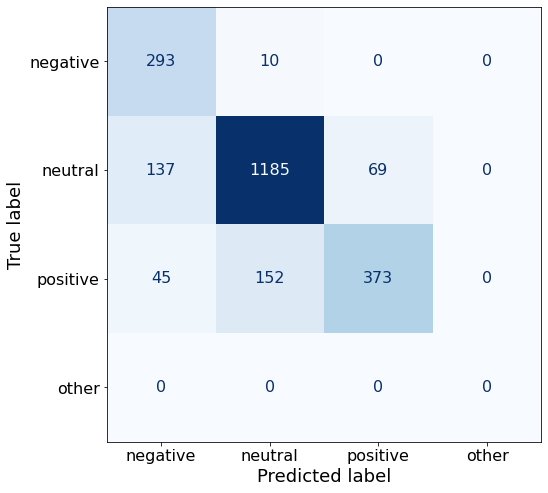

In [26]:
make_cm(df)

In [16]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_A.csv', index=False)

## Prompt B

I'll repeat the instruction after providing the sentence, as this has usually improved performance.

In [19]:
promptB = """Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}
label the TEXT with a single word: negative, positive, or neutral"""

In [20]:
df, acc = generate_responses(dataset, promptB)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
label the TEXT with a single word: negative, positive, or neutral


Interesting! Repeating the instruction usually increases the accuracy. Here, it drops by about 30%!

In [21]:
acc

0.5185512367491166

The model actually gets better at `negative` classification but significantly plummets for the other two.

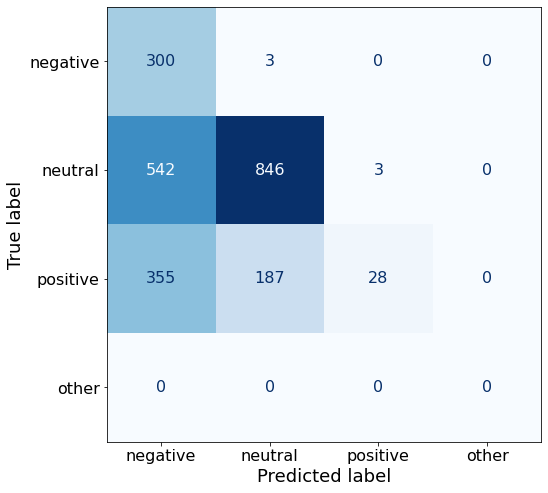

In [22]:
make_cm(df)

In [23]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_B.csv', index=False)

## Prompt C

I'll return to Prompt A and change the format a bit.

In [28]:
promptC = """Respond with a single word: negative, positive, or neutral
TEXT: {text}"""

In [29]:
df, acc = generate_responses(dataset, promptC)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Respond with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


This yields a similar accuracy to Prompt A.

In [30]:
acc

0.8140459363957597

The model does quite well with `neutral` and `negative` sentences but terribly with `positive` sentences.
In fact, Qwen2-1.5B-Instruct (96%) beats the best-performing phi-3 prompt (94%) in `neutral` True Positive Rate (TPR).

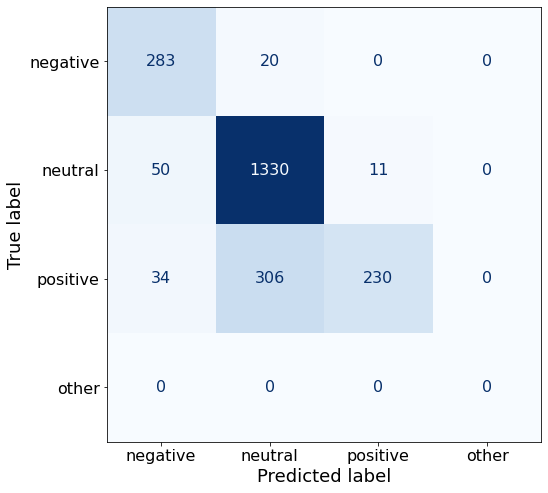

In [31]:
make_cm(df)

In [32]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_C.csv', index=False)

## Prompt D

I'll add a period after the instruction.

In [34]:
promptD = """Respond with a single word: negative, positive, or neutral.
TEXT: {text}"""

In [35]:
df, acc = generate_responses(dataset, promptD)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Respond with a single word: negative, positive, or neutral.
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


Nope! Period == bad.

In [36]:
acc

0.7853356890459364

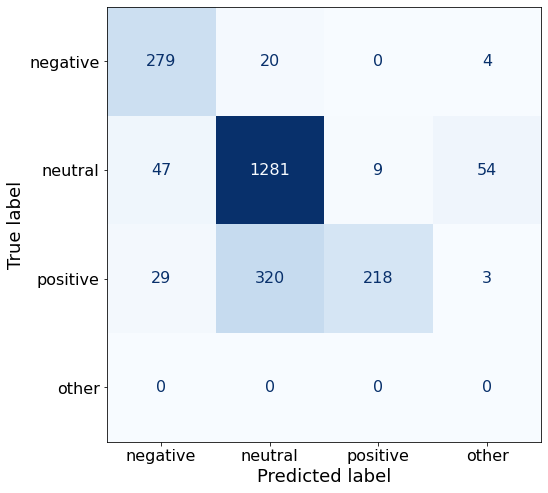

In [37]:
make_cm(df)

In [38]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_D.csv', index=False)

## Prompt E

I'll repeat the instruction to see if it improves performance.

In [40]:
promptE = """Respond with a single word: negative, positive, or neutral
TEXT: {text}
Respond with a single word: negative, positive, or neutral"""

In [41]:
df, acc = generate_responses(dataset, promptE)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Respond with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Respond with a single word: negative, positive, or neutral


Nope! The repeated instruction decreases the accuracy.

In [42]:
acc

0.6621024734982333

Note that the `negative` sentiment TPR is near perfect.

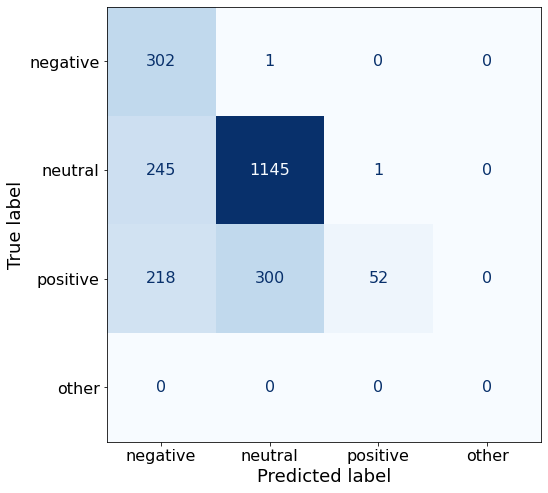

In [43]:
make_cm(df)

In [44]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_E.csv', index=False)

## Prompt F

I realized I didn't have "Instruct:" at the start of the prompt so I'll add that to Prompt C.

In [45]:
promptF = """Instruct: Respond with a single word: negative, positive, or neutral
TEXT: {text}"""

In [46]:
df, acc = generate_responses(dataset, promptF)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Instruct: Respond with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


That decreases the accuracy by 3%.

In [47]:
acc

0.7804770318021201

Note that this prompt yields the best `neutral` TPR so far (1355/1391 = 97.4%) for this model.

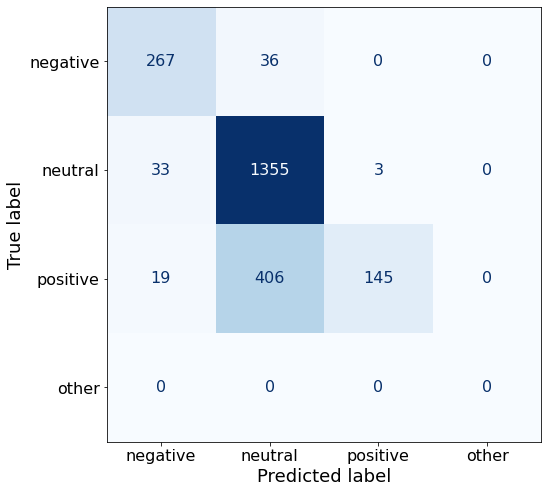

In [48]:
make_cm(df)

In [49]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_F.csv', index=False)

## Prompt G

I'll now add some additional instructions.

In [51]:
promptG = """Your task is to analyze the sentiment (from an investor's perspective) of the text below.
Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: {text}"""

In [52]:
df, acc = generate_responses(dataset, promptG)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Your task is to analyze the sentiment (from an investor's perspective) of the text below.
Instruct: label the following TEXT with a single word: negative, positive, or neutral
TEXT: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .


Additional instruction worsens the model's performance by ~15%.

In [53]:
acc

0.6669611307420494

Nothing immediately notable about the results.

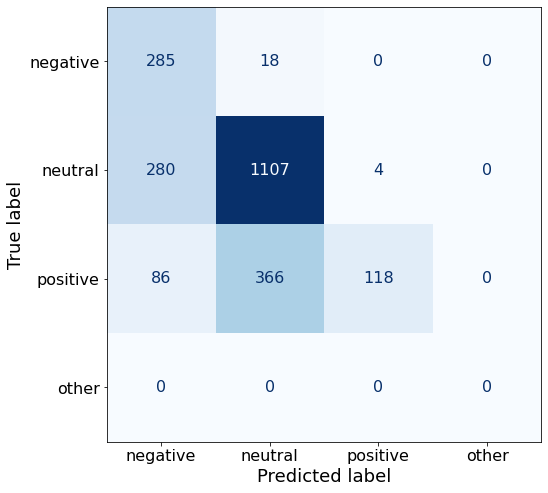

In [54]:
make_cm(df)

In [55]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_G.csv', index=False)

## Prompt H

I'll now try a series of prompts suggested by Claude (based on the previous prompts and accuracies achieved). These prompts are 
simple and concise.

In [57]:
promptH = """Sentiment: {text}
Output: [negative/positive/neutral]"""

In [58]:
df, acc = generate_responses(dataset, promptH)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Sentiment: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Output: [negative/positive/neutral]


I'm surprised that such a simple prompt performs well, though it's 11% worse than my best prompts so far.

In [59]:
acc

0.708922261484099

What's notable about this prompt's results is the incredibly bad performance on `positive` sentiment (18%). Also noteworthy is 
that with this prompt there are now `other` responses than `negative`, `neutral` or `positive`.

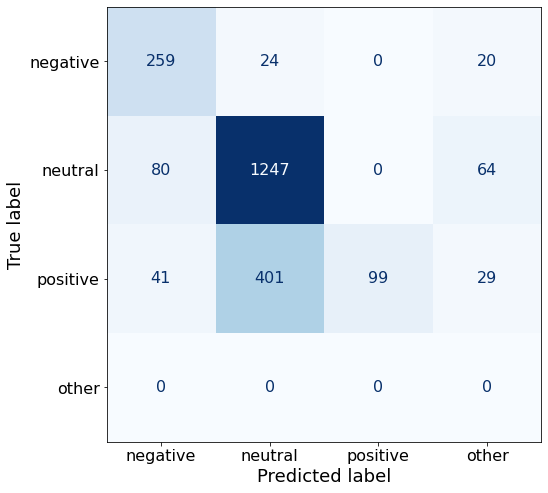

In [60]:
make_cm(df)

In [61]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_H.csv', index=False)

## Prompt I

Another prompt suggested by Claude.

In [62]:
promptI = """Classify sentiment: {text}
Answer: [negative/positive/neutral]"""

In [63]:
df, acc = generate_responses(dataset, promptI)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Classify sentiment: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Answer: [negative/positive/neutral]


A similar performance to Prompt H.

In [64]:
acc

0.691696113074205

This prompt performs worse for all three sentiments, but especially `negative` and `positive`.

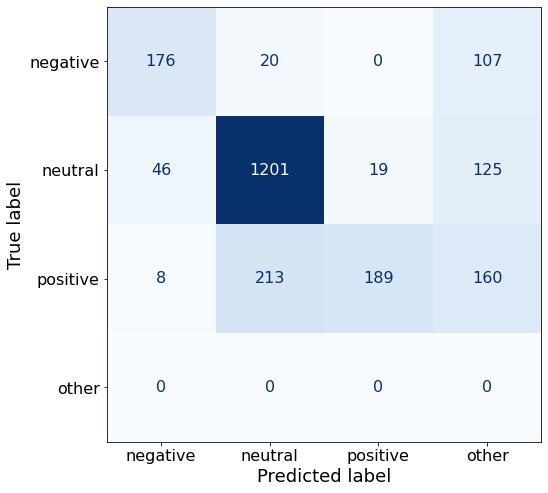

In [65]:
make_cm(df)

In [66]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_I.csv', index=False)

## Prompt J

In [67]:
promptJ = """Text: {text}
Sentiment classification: [negative/positive/neutral]"""

In [68]:
df, acc = generate_responses(dataset, promptJ)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Text: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Sentiment classification: [negative/positive/neutral]


This prompt yields a significantly worse performance.

In [69]:
acc

0.5737632508833922

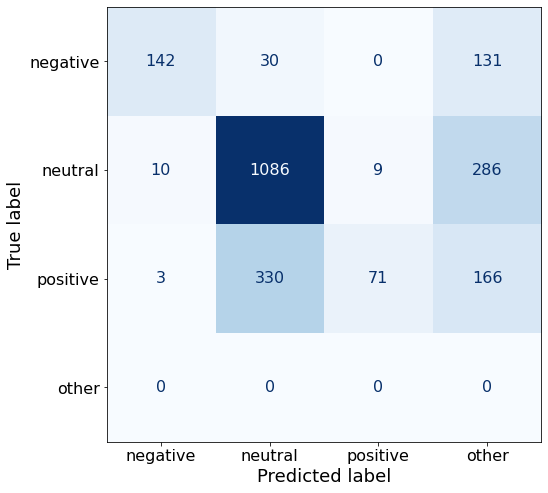

In [70]:
make_cm(df)

In [71]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_J.csv', index=False)

## Prompt K

Another Claude suggested prompt:

In [72]:
promptK = """Analyze the sentiment of this text:
{text}
Classification: [negative/positive/neutral]"""

In [73]:
df, acc = generate_responses(dataset, promptK)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Analyze the sentiment of this text:
According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Classification: [negative/positive/neutral]


This prompt yields worse results.

In [74]:
acc

0.41872791519434627

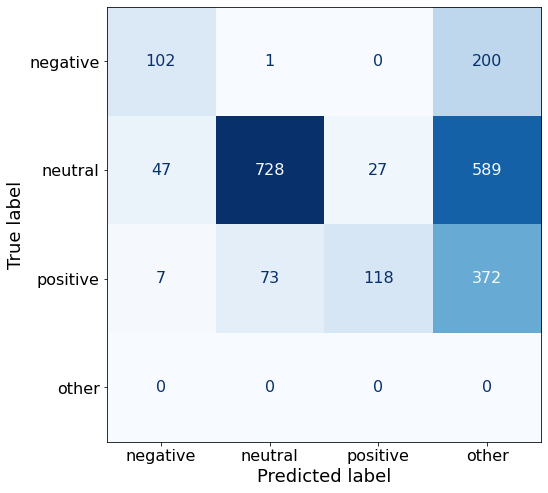

In [75]:
make_cm(df)

In [76]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_K.csv', index=False)

## Prompt L

Another Claude suggested prompt (so far, has not yielded good results!).

In [77]:
promptL = """Categorize the following text as negative, positive, or neutral:
{text}
Category:"""

In [78]:
df, acc = generate_responses(dataset, promptL)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Categorize the following text as negative, positive, or neutral:
According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Category:


Another subpar result.

In [79]:
acc

0.4284452296819788

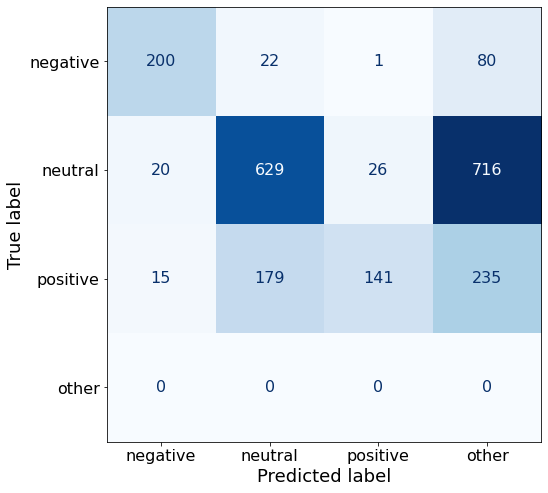

In [80]:
make_cm(df)

In [81]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_L.csv', index=False)

## Prompt M

Another Claude suggested prompt (3 more left to try out!)

In [82]:
promptM = """Sentiment analysis task:
Input: {text}
Output: [negative/positive/neutral]"""

In [83]:
df, acc = generate_responses(dataset, promptM)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Sentiment analysis task:
Input: According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Output: [negative/positive/neutral]


Nope! No success with this one either (well, 51% success).

In [84]:
acc

0.5145759717314488

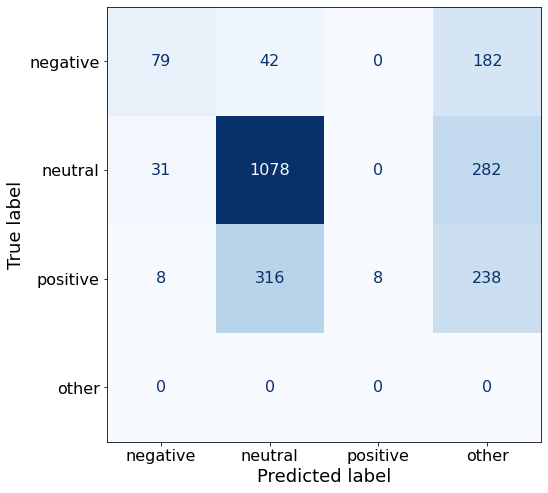

In [85]:
make_cm(df)

In [86]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_M.csv', index=False)

## Prompt N

In [88]:
promptN = """determine the sentiment:
{text}
sentiment: [negative/positive/neutral]"""

In [89]:
df, acc = generate_responses(dataset, promptN)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

determine the sentiment:
According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
sentiment: [negative/positive/neutral]


This one was particularly bad.

In [90]:
acc

0.29770318021201414

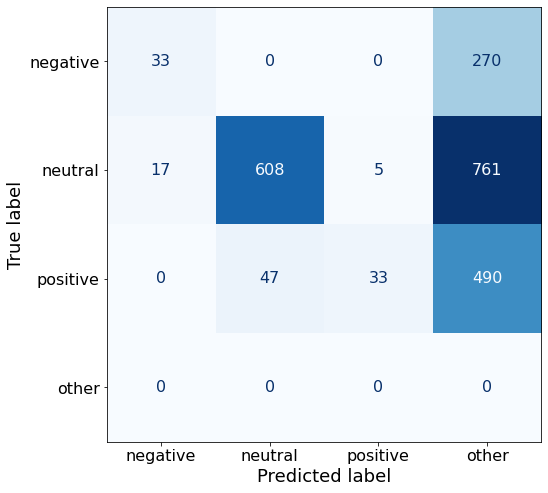

In [91]:
make_cm(df)

In [92]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_N.csv', index=False)

## Prompt O

In [93]:
promptO = """Sentiment classification task:
'{text}'
Label: [negative/positive/neutral]"""

In [94]:
df, acc = generate_responses(dataset, promptO)

Map:   0%|          | 0/2264 [00:00<?, ? examples/s]

Sentiment classification task:
'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'
Label: [negative/positive/neutral]


Looks like I'll stick with Prompt A for now!

In [95]:
acc

0.609982332155477

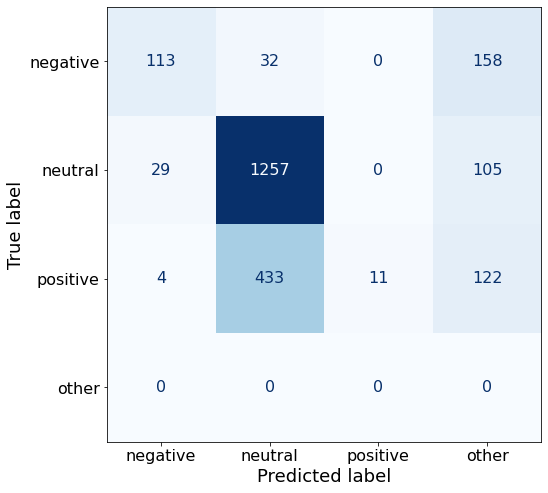

In [96]:
make_cm(df)

In [97]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_O.csv', index=False)

## Prompt P

I'll revisit Prompt A and give it a few examples.

In [10]:
#| code-fold: true
#| code-summary: "Show updated `few_shot_responses` function"
def few_shot_responses(dataset, prompt, examples):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})
    print(dataset[0]['prompt'])
    
    few_shot_examples = []
    
    for example in examples:
        few_shot_examples.append({"role": "user", "content": prompt.format(text=example[0])})
        few_shot_examples.append({"role": "assistant", "content": example[1]})
    
    for row in dataset:
        messages = few_shot_examples + [{"role": "user", "content": row['prompt']}]
        
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        model_inputs = tokenizer([text], return_tensors="pt").to(device)

        generated_ids = model.generate(
            model_inputs.input_ids,
            max_new_tokens=2
        )
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].strip().lower()
        responses.append(response)
        
    # calculate accuracy
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
    df['lm_match'] = df['label_text'] == df['responses']
    acc = df.lm_match.mean()
    
    return df, acc

In [99]:
exclude_idxs = [0, 1, 292]

In [102]:
promptP_ds = ds_subset(dataset, exclude_idxs)
promptP_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2261
})

In [103]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

examples

[('According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
  'neutral'),
 ("For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
  'positive'),
 ('Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .',
  'negative')]

In [104]:
df, acc = few_shot_responses(promptP_ds, promptA, examples)

Map:   0%|          | 0/2261 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .


3-Shot prompting does not improve performance.

In [105]:
acc

0.7819548872180451

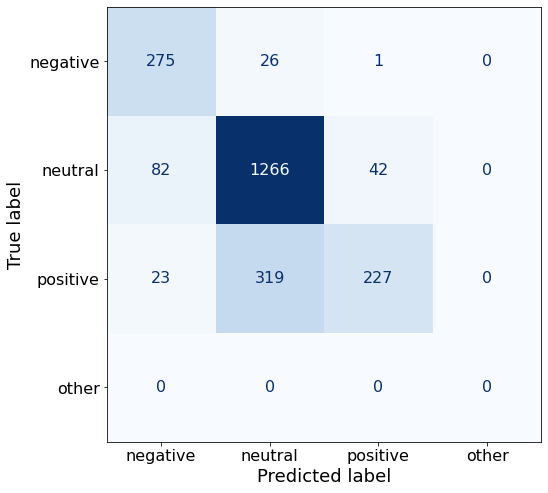

In [106]:
make_cm(df)

In [107]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_P.csv', index=False)

## Prompt Q

I'll try 6-Shot prompting next.

In [110]:
exclude_idxs=[0, 1, 292, 37, 38, 39]
promptQ_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptQ_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2258
})

In [111]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

6

In [112]:
df, acc = few_shot_responses(promptQ_ds, promptA, examples)

Map:   0%|          | 0/2258 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .


6-Shot doesn't fare much better.

In [113]:
acc

0.7692648361381754

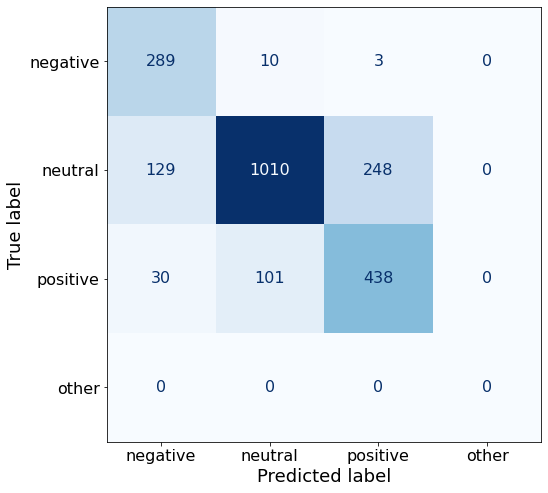

In [114]:
make_cm(df)

In [115]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_Q.csv', index=False)

## Prompt R

I'll now bump it up to 20 examples.

In [117]:
exclude_idxs = [
    1, 2, 3, 4, # positive
    292, 293, 294, 347, # negative
    0, 37, 38, 39, 40, 263, 264, 265, 266, 270, 274, 283 # neutral
]

In [118]:
promptR_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptR_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2244
})

In [119]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

20

In [120]:
df, acc = few_shot_responses(promptR_ds, promptA, examples)

Map:   0%|          | 0/2244 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: Finnish Talentum reports its operating profit increased to EUR 20.5 mn in 2005 from EUR 9.3 mn in 2004 , and net sales totaled EUR 103.3 mn , up from EUR 96.4 mn .


Interestingly, the 20-Shot prompt yields a worse accuracy than the 0-Shot prompt.

In [121]:
acc

0.8141711229946524

Compared to 0-Shot Prompt A (85%), the 20-Shot prompt has a significantly higher TPR for `neutral` 
sentiment (94%) whereas `negative` and `positive` perform worse.

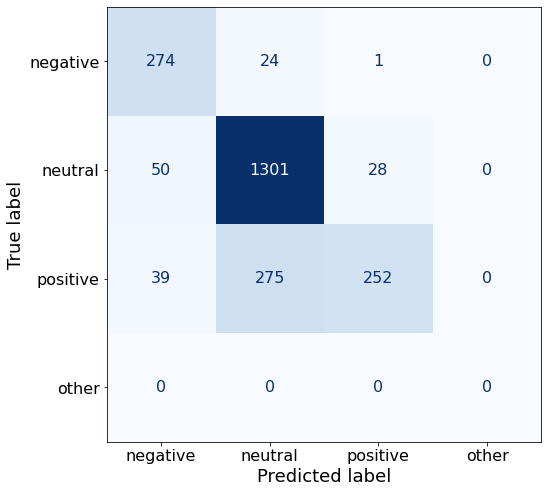

In [122]:
make_cm(df)

In [123]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_R.csv', index=False)

## Prompt S

I'll increase the number of examples to 30, but will only add `negative` and `positive` examples as 
the model's performance was lacking for those sentiments.

In [134]:
exclude_idxs = [
    1, 2, 3, 4, 5, 6, 7, 8, 9,  # positive
    292, 293, 294, 347, 348, 349, 350, 351, 352, # negative
    0, 37, 38, 39, 40, 263, 264, 265, 266, 270, 274, 283 # neutral
]

In [135]:
promptS_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptS_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2234
})

In [136]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

30

In [137]:
df, acc = few_shot_responses(promptS_ds, promptA, examples)

Map:   0%|          | 0/2234 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: Its board of directors will propose a dividend of EUR0 .12 per share for 2010 , up from the EUR0 .08 per share paid in 2009 .


Increasing the number of examples and changing the proportions has not improved the overall accuracy.

In [138]:
acc

0.815129811996419

Interestingly, the number of correctly predicted `neutral` sentences has increased with this prompt 
while the number of correctly predicted `negative` and `positive` sentences decreased.

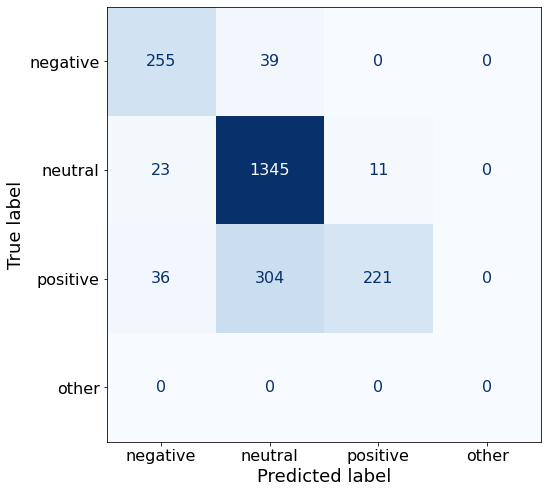

In [139]:
make_cm(df)

In [140]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_S.csv', index=False)

## Prompt T

As the number of examples have increased, the model is classifying more and more negative 
and positive sentences as neutral. After chatting with Claude: I'll start removing neutral sentences from the example to see 
if that reverses this trend.

I'll start by giving the model 9 examples per sentiment.

In [143]:
exclude_idxs = [
    1, 2, 3, 4, 5, 6, 7, 8, 9,  # positive
    292, 293, 294, 347, 348, 349, 350, 351, 352, # negative
    0, 37, 38, 39, 40, 263, 264, 265, 266 # neutral
]

In [144]:
promptT_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptT_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2237
})

In [145]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

27

In [146]:
df, acc = few_shot_responses(promptT_ds, promptA, examples)

Map:   0%|          | 0/2237 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: Its board of directors will propose a dividend of EUR0 .12 per share for 2010 , up from the EUR0 .08 per share paid in 2009 .


Hooray! This strategy yielded results. The accuracy increases by a couple percent.

In [147]:
acc

0.8372820742065266

The `neutral` TPR has decreased, as expected, but `negative` and `positive` are now making a comeback.

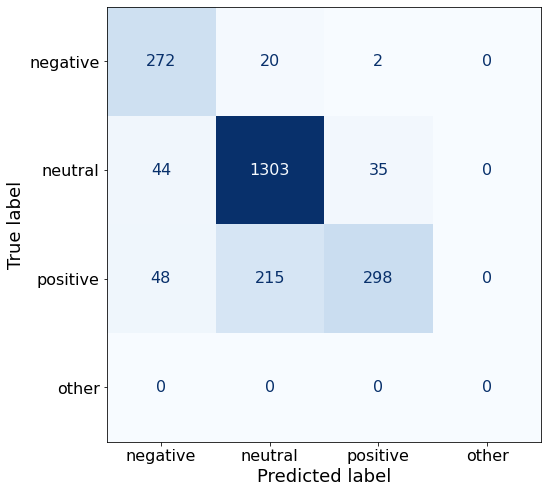

In [148]:
make_cm(df)

In [149]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_T.csv', index=False)

## Prompt U

I'll continue to decrease the number of examples, this time by decreasing the number of neutral examples.

In [151]:
exclude_idxs = [
    1, 2, 3, 4, 5, 6, 7, 8, 9,  # positive
    292, 293, 294, 347, 348, 349, 350, 351, 352, # negative
    0, 37, 38, 39, 40, 263, 264 # neutral
]

In [152]:
promptU_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptU_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2239
})

In [153]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

25

In [154]:
df, acc = few_shot_responses(promptU_ds, promptA, examples)

Map:   0%|          | 0/2239 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: Its board of directors will propose a dividend of EUR0 .12 per share for 2010 , up from the EUR0 .08 per share paid in 2009 .


Decreasing the number of neutral examples decreases the accuracy. 

In [155]:
acc

0.829388119696293

The model is actually worse at predicting `negative` and `positive` sentences.

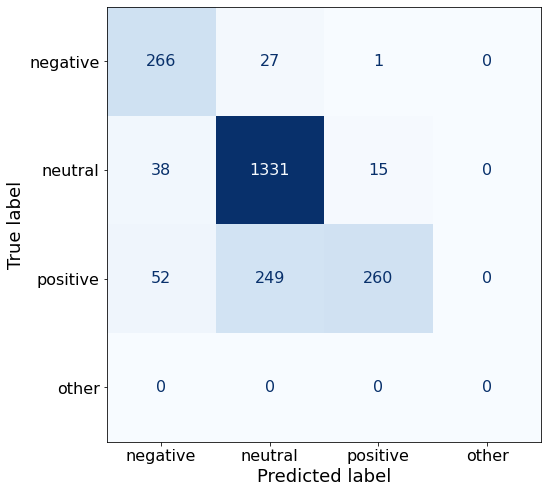

In [156]:
make_cm(df)

In [157]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_U.csv', index=False)

## Prompt V

I'll continue decreasing examples, with equal amounts from each sentiment for a 21-Shot prompt.

In [161]:
exclude_idxs = [
    1, 2, 3, 4, 5, 6, 7, # positive
    292, 293, 294, 347, 348, 349, 350,  # negative
    0, 37, 38, 39, 40, 263, 264 # neutral
]

In [162]:
promptV_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptV_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2243
})

In [163]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

21

In [164]:
df, acc = few_shot_responses(promptV_ds, promptA, examples)

Map:   0%|          | 0/2243 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: Foundries division reports its sales increased by 9.7 % to EUR 63.1 mn from EUR 57.5 mn in the corresponding period in 2006 , and sales of the Machine Shop division increased by 16.4 % to EUR 41.2 mn from EUR 35.4 mn in the corresponding period in 2006 .


The accuracy improves, but is still second-best so far.

In [165]:
acc

0.8328131966116807

Compared to my best-performing prompting strategy, this prompt yields one more correct `negative` sentence, 11 more correct 
`neutral`s and 17 fewer correct `positive`s.

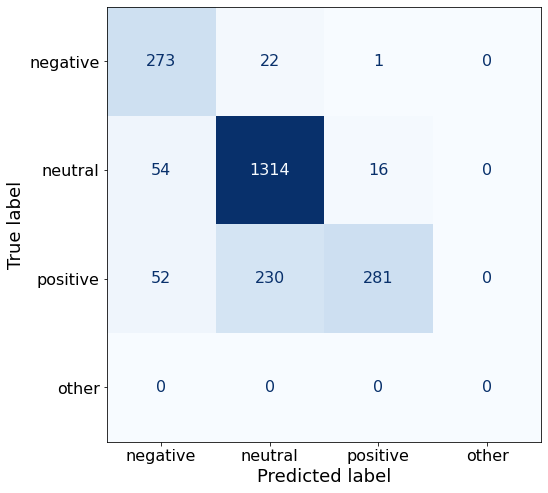

In [166]:
make_cm(df)

In [167]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_V.csv', index=False)

## Prompt W

I'll try one more reduction in examples to 15 before increasing them past 27.

In [168]:
exclude_idxs = [
    1, 2, 3, 4, 5,  # positive
    292, 293, 294, 347, 348,   # negative
    0, 37, 38, 39, 40 # neutral
]

In [169]:
promptW_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptW_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2249
})

In [170]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

15

In [171]:
df, acc = few_shot_responses(promptW_ds, promptA, examples)

Map:   0%|          | 0/2249 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: Clothing retail chain Sepp+ñl+ñ 's sales increased by 8 % to EUR 155.2 mn , and operating profit rose to EUR 31.1 mn from EUR 17.1 mn in 2004 .


Decreasing the number of examples to 15 has worsened the accuracy.

In [173]:
acc

0.8154735437972432

Interestingly, here the `negative` and `positive` sentiments perform better but `neutral` performs worse (compared to the best-
performing prompt).

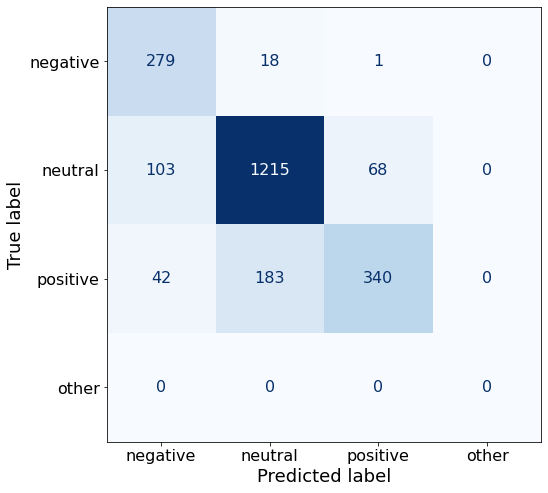

In [174]:
make_cm(df)

In [175]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_W.csv', index=False)

## Prompt X

I'll now go in the other direction and increase the number of prompts from 27 to 30 (10 per sentiment).

In [179]:
exclude_idxs = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10,  # positive
    292, 293, 294, 347, 348, 349, 350, 351, 352, 353, # negative
    0, 37, 38, 39, 40, 263, 264, 265, 266, 270 # neutral
]

In [182]:
promptX_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptX_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2234
})

In [183]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

30

In [184]:
df, acc = few_shot_responses(promptX_ds, promptA, examples)

Map:   0%|          | 0/2234 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: MegaFon 's subscriber base increased 16.1 % in 2009 to 50.5 million users as of December 31 , while its market share by the number of customers amounted to 24 % as of late 2009 , up from 23 % as of late 2008 , according to TeliaSonera estimates .


Nope! Increasing the prompts to 30 doesn't yield better results.

In [185]:
acc

0.8173679498657117

A similar trend as before is appearing: the model gets a lot better at predicting `neutral` sentences at the cost of 
`negative` and `positive` sentences.

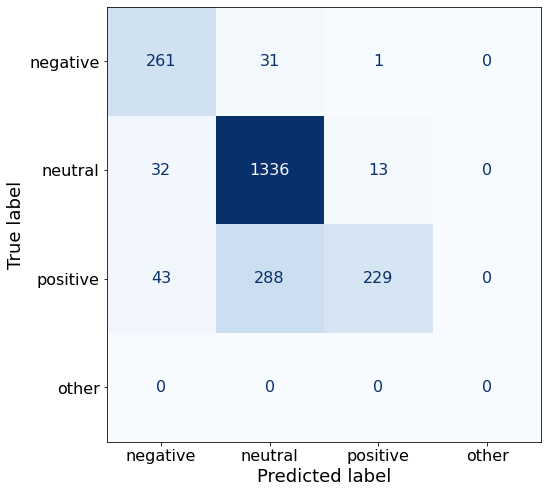

In [186]:
make_cm(df)

In [187]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_X.csv', index=False)

## Prompt Y

Before I return to the best-performing 21-Shot prompt, I'll try and give the model a significantly higher number of 
examples (60) to see if that improves performance.

In [47]:
exclude_idxs = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,# positive
    292, 293, 294, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 370, # negative
    0, 37, 38, 39, 40, 263, 264, 265, 266, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280 # neutral
]

In [50]:
promptY_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptY_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2204
})

In [51]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

60

In [54]:
df, acc = few_shot_responses(promptY_ds, promptA, examples)

Map:   0%|          | 0/2204 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: The fair value of the property portfolio doubled as a result of the Kapiteeli acquisition and totalled EUR 2,686.2 1,259.7 million .


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Nope! 60 examples does not improve performance.

In [55]:
acc

0.7581669691470054

Interestingly this prompt causes the model to perform ridiculously well on `neutral` sentences (1368/1371 = 99.8%), 
but abysmally on `negative` and especially `positive` sentences (117/550 = 21%).

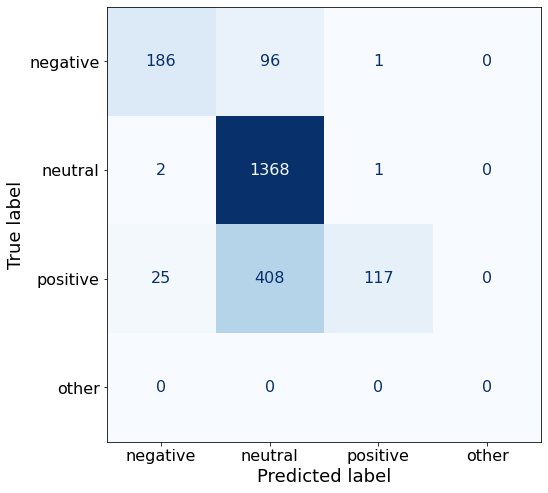

In [56]:
make_cm(df)

In [57]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_Y.csv', index=False)

## Prompt Z

I'll return to the best-performing prompt: 27-Shot Prompt A. I'll see if adding instructions helps.

In [67]:
promptZ = """Label the following TEXT with a single word: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
TEXT: {text}"""

In [68]:
print(promptZ)

Label the following TEXT with a single word: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
TEXT: {text}


In [69]:
exclude_idxs = [
    1, 2, 3, 4, 5, 6, 7, 8, 9,  # positive
    292, 293, 294, 347, 348, 349, 350, 351, 352, # negative
    0, 37, 38, 39, 40, 263, 264, 265, 266 # neutral
]

In [70]:
promptZ_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptZ_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2237
})

In [71]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

27

In [72]:
df, acc = few_shot_responses(promptZ_ds, promptZ, examples)

Map:   0%|          | 0/2237 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral. If the amount of money is not explicitly increasing or decreasing, respond with neutral.
TEXT: Its board of directors will propose a dividend of EUR0 .12 per share for 2010 , up from the EUR0 .08 per share paid in 2009 .


The modified prompt resulted in a ~2% drop in accuracy.

In [73]:
acc

0.813589628967367

This prompt performs better than the best-performing one for `neutral` sentences (1374 > 1300) at the cost of `negative` and `positive` sentences.

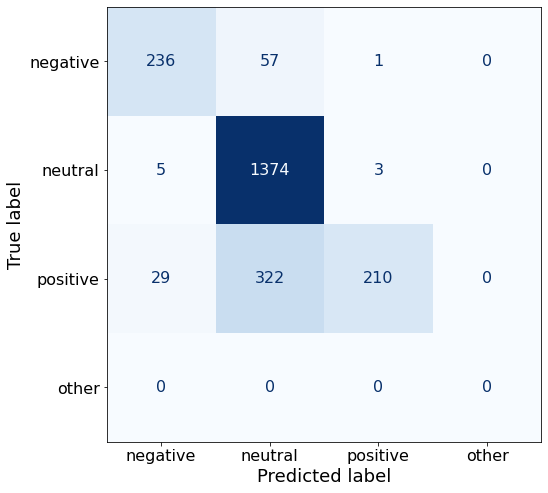

In [74]:
make_cm(df)

In [75]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_Z.csv', index=False)

## Prompt AA

Since `positive` sentiment is performing the worst, I'll see if reducing `neutral` and `negative` examples improves its performance. 
I'll stick with the original Prompt A.

In [78]:
exclude_idxs = [
    1, 2, 3, 4, 5, 6, 7, 8, 9,  # positive
    292, 293, 294, 347, 348, 349, 350,  # negative
    0, 37, 38, 39, 40, 263, 264 # neutral
]

In [79]:
promptAA_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptAA_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2241
})

In [80]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

23

In [81]:
df, acc = few_shot_responses(promptAA_ds, promptA, examples)

Map:   0%|          | 0/2241 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: Its board of directors will propose a dividend of EUR0 .12 per share for 2010 , up from the EUR0 .08 per share paid in 2009 .


The overall accuracy drops a bit.

In [82]:
acc

0.8295403837572513

The `positive` performance deteriorates while `negative` and `neutral` get better.

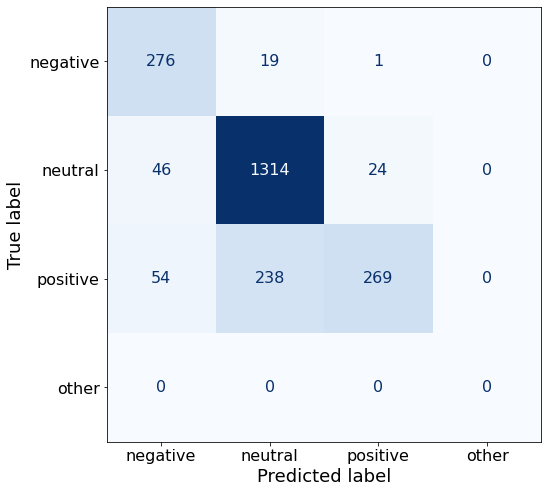

In [83]:
make_cm(df)

In [90]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_AA.csv', index=False)

## Prompt AB

I'll now reduce the `positive` examples while keeping the other two the same as my best-performing prompt.

In [91]:
exclude_idxs = [
    1, 2, 3, 4, 5, 6, 7,  # positive
    292, 293, 294, 347, 348, 349, 350, 351, 352, # negative
    0, 37, 38, 39, 40, 263, 264, 265, 266 # neutral
]

In [92]:
promptAB_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptAB_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2239
})

In [93]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

25

In [94]:
df, acc = few_shot_responses(promptAB_ds, promptA, examples)

Map:   0%|          | 0/2239 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: Foundries division reports its sales increased by 9.7 % to EUR 63.1 mn from EUR 57.5 mn in the corresponding period in 2006 , and sales of the Machine Shop division increased by 16.4 % to EUR 41.2 mn from EUR 35.4 mn in the corresponding period in 2006 .


While still a bit lower than my best-performing accuracy, this approach might be worth expanding on.

In [95]:
acc

0.8369807949977669

The number of correctly predicted `neutral` sentences increases, while the other two decrease.

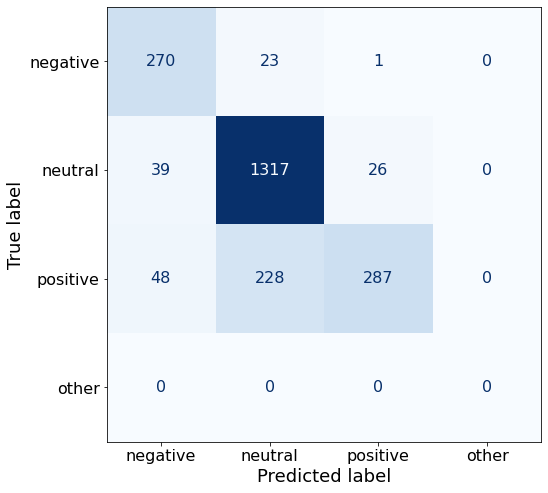

In [96]:
make_cm(df)

In [97]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_AB.csv', index=False)

## Prompt AC

I'll continue reducing `positive` examples.

In [98]:
exclude_idxs = [
    1, 2, 3, 4, 5,  # positive
    292, 293, 294, 347, 348, 349, 350, 351, 352, # negative
    0, 37, 38, 39, 40, 263, 264, 265, 266 # neutral
]

In [99]:
promptAC_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptAC_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2241
})

In [100]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

23

In [101]:
df, acc = few_shot_responses(promptAC_ds, promptA, examples)

Map:   0%|          | 0/2241 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: Clothing retail chain Sepp+ñl+ñ 's sales increased by 8 % to EUR 155.2 mn , and operating profit rose to EUR 31.1 mn from EUR 17.1 mn in 2004 .


Nope! That doesn't improve accuracy.

In [102]:
acc

0.8340026773761714

`neutral` and `positive` sentences are correctly predicted at a worse rate, `negative` sentences predicted a bit better.

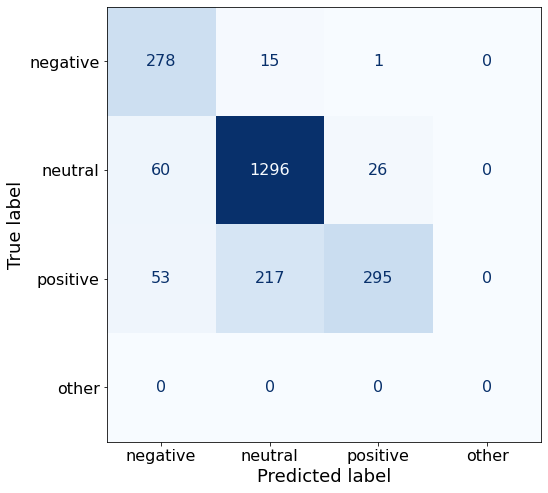

In [103]:
make_cm(df)

In [104]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_AC.csv', index=False)

## Prompt AD

As I was staring at `exclude_idxs` I realized that they are sorted by sentiment with `positive` first,
then `negative` and then `neutral`. Perhaps this order affects the generations? I'll try randomizing the order of the 
27 examples that yielded the best accuracy.

In [11]:
exclude_idxs = [
    1, 2, 3, 4, 5, 6, 7, 8, 9,  # positive
    292, 293, 294, 347, 348, 349, 350, 351, 352, # negative
    0, 37, 38, 39, 40, 263, 264, 265, 266 # neutral
]

In [12]:
random.shuffle(exclude_idxs)
exclude_idxs

[293,
 266,
 264,
 6,
 347,
 7,
 263,
 9,
 38,
 37,
 0,
 352,
 5,
 4,
 351,
 350,
 40,
 294,
 1,
 8,
 349,
 2,
 348,
 292,
 3,
 39,
 265]

In [13]:
promptAD_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptAD_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2237
})

In [14]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

27

In [17]:
df, acc = few_shot_responses(promptAD_ds, promptA, examples)

Map:   0%|          | 0/2237 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: Its board of directors will propose a dividend of EUR0 .12 per share for 2010 , up from the EUR0 .08 per share paid in 2009 .


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Wow, that actually improved my accuracy! It's making me question all previous few-shot prompt results!

In [18]:
acc

0.8609745194456861

`negative` TPR decreases, `neutral` and `positive` increase quite a bit!

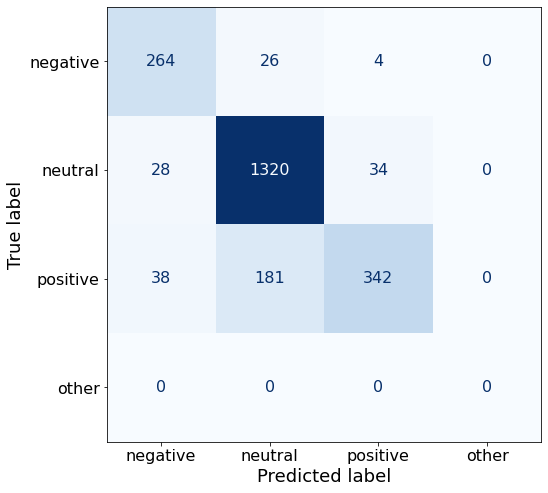

In [19]:
make_cm(df)

In [22]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_AD.csv', index=False)

## Prompt AE

I'll return to my 60-Shot prompt and shuffle the examples to see if that improves the accuracy.

In [118]:
exclude_idxs = [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,# positive
    292, 293, 294, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 370, # negative
    0, 37, 38, 39, 40, 263, 264, 265, 266, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280 # neutral
]

In [119]:
random.shuffle(exclude_idxs)
exclude_idxs[:5]

[15, 37, 358, 16, 0]

In [120]:
promptAE_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptAE_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2204
})

In [121]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

60

In [122]:
df, acc = few_shot_responses(promptAE_ds, promptA, examples)

Map:   0%|          | 0/2204 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: The fair value of the property portfolio doubled as a result of the Kapiteeli acquisition and totalled EUR 2,686.2 1,259.7 million .


The shuffled 60-Shot prompt does not yield better results.

In [123]:
acc

0.8371143375680581

Interestingly it gets the same number of `neutral` sentences right (1341) but get lower counts for the other two.

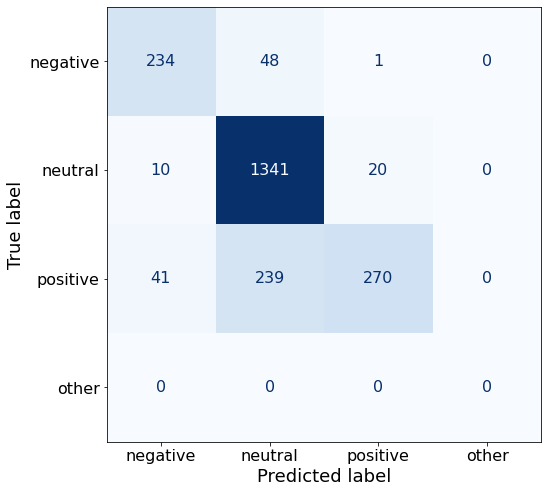

In [124]:
make_cm(df)

In [125]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_AE.csv', index=False)

## Prompt AF

I'll now try a shuffled 15-Shot prompt.

In [126]:
exclude_idxs = [
    1, 2, 3, 4, 5,  # positive
    292, 293, 294, 347, 348,   # negative
    0, 37, 38, 39, 40 # neutral
]

In [127]:
random.shuffle(exclude_idxs)
exclude_idxs[:5]

[292, 38, 1, 0, 4]

In [128]:
promptAF_ds = ds_subset(dataset, exclude_idxs=exclude_idxs)
promptAF_ds

Dataset({
    features: ['sentence', 'label', 'label_text', '__index_level_0__'],
    num_rows: 2249
})

In [129]:
examples = []
for idx in exclude_idxs:
    examples.append((dataset[idx]['sentence'], dataset[idx]['label_text']))

len(examples)

15

In [130]:
df, acc = few_shot_responses(promptAF_ds, promptA, examples)

Map:   0%|          | 0/2249 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: Clothing retail chain Sepp+ñl+ñ 's sales increased by 8 % to EUR 155.2 mn , and operating profit rose to EUR 31.1 mn from EUR 17.1 mn in 2004 .


Shuffling the 15-Shot prompt doesn't beat the 27-Shot prompt.

In [131]:
acc

0.8199199644286349

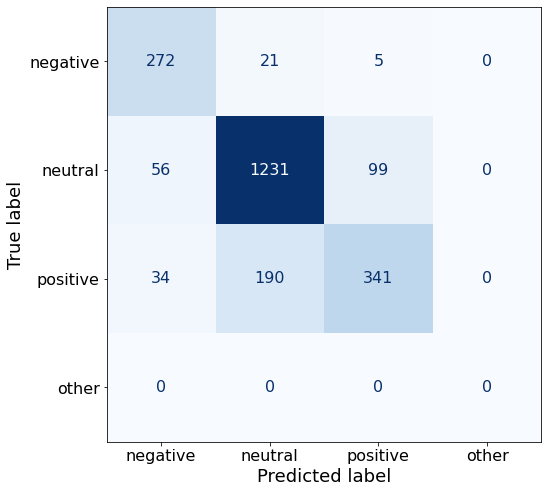

In [132]:
make_cm(df)

In [133]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_AF.csv', index=False)

## Prompt AG

The last thing I'll experiment with is adding a system prompt.

In [23]:
#| code-fold: true
#| code-summary: "Show updated `few_shot_responses` function"
def few_shot_responses(dataset, prompt, examples, sp):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})
    print(dataset[0]['prompt'])
    
    few_shot_examples = []
    
    for example in examples:
        few_shot_examples.append({"role": "user", "content": prompt.format(text=example[0])})
        few_shot_examples.append({"role": "assistant", "content": example[1]})
    
    for row in dataset:
        messages = [{"role": "system", "content": sp}] + few_shot_examples + [{"role": "user", "content": row['prompt']}]
        
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        model_inputs = tokenizer([text], return_tensors="pt").to(device)

        generated_ids = model.generate(
            model_inputs.input_ids,
            max_new_tokens=2
        )
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].strip().lower()
        responses.append(response)
        
    # calculate accuracy
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
    df['lm_match'] = df['label_text'] == df['responses']
    acc = df.lm_match.mean()
    
    return df, acc

In [24]:
sp = "You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral. Consider terms like 'growth', 'decline', 'improvement', or 'deterioration' as indicators of change."

In [25]:
print(sp)

You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification. If the amount of money, market share, or key performance indicators are not explicitly increasing or decreasing, respond with neutral. Consider terms like 'growth', 'decline', 'improvement', or 'deterioration' as indicators of change.


In [26]:
df, acc = few_shot_responses(promptAD_ds, promptA, examples, sp)

Map:   0%|          | 0/2237 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: Its board of directors will propose a dividend of EUR0 .12 per share for 2010 , up from the EUR0 .08 per share paid in 2009 .


This particular system prompt doesn't improve the accuracy.

In [27]:
acc

0.8439874832364774

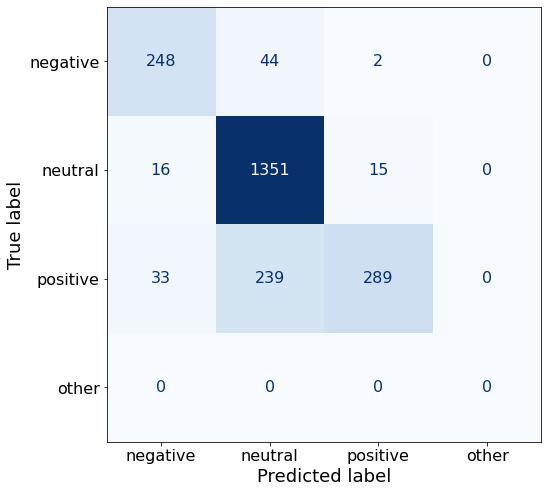

In [28]:
make_cm(df)

In [30]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_AG.csv', index=False)

## Prompt AH

I'll simplify the system prompt.

In [31]:
sp = "You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification."

In [32]:
print(sp)

You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral. Consider the overall impact and implications of the statement when making your classification.


In [33]:
df, acc = few_shot_responses(promptAD_ds, promptA, examples, sp)

Map:   0%|          | 0/2237 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: Its board of directors will propose a dividend of EUR0 .12 per share for 2010 , up from the EUR0 .08 per share paid in 2009 .


Using a simpler system prompt lowers the accuracy.

In [34]:
acc

0.8466696468484578

The model gets 22 more `neutral` sentences correct but does worse on `negative` and `positive` sentences (when 
compared to the best-performing Prompt AD).

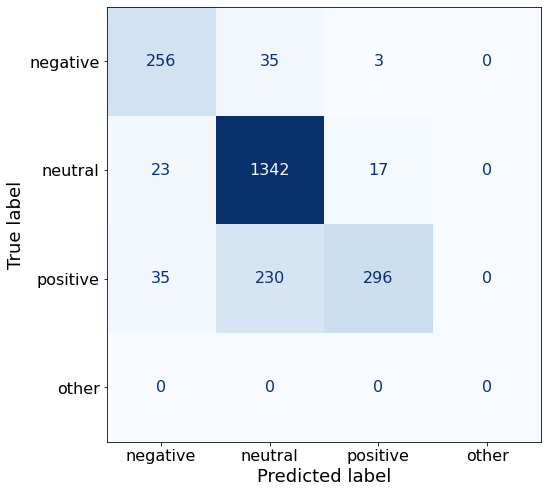

In [37]:
make_cm(df)

In [38]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_AH.csv', index=False)

## Prompt AI

I'll further simplify the system prompt.

In [41]:
sp = "You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral."

In [42]:
print(sp)

You are an expert in financial sentiment analysis. Your task is to accurately classify the sentiment of financial statements as negative, positive, or neutral.


In [43]:
df, acc = few_shot_responses(promptAD_ds, promptA, examples, sp)

Map:   0%|          | 0/2237 [00:00<?, ? examples/s]

Label the following TEXT with a single word: negative, positive, or neutral
TEXT: Its board of directors will propose a dividend of EUR0 .12 per share for 2010 , up from the EUR0 .08 per share paid in 2009 .


I still can't recover (or improve upon) the best-performing accuracy of 86%.

In [44]:
acc

0.8439874832364774

The `neutral` performance continues to increase while `negative` and `positive` sentences suffer.

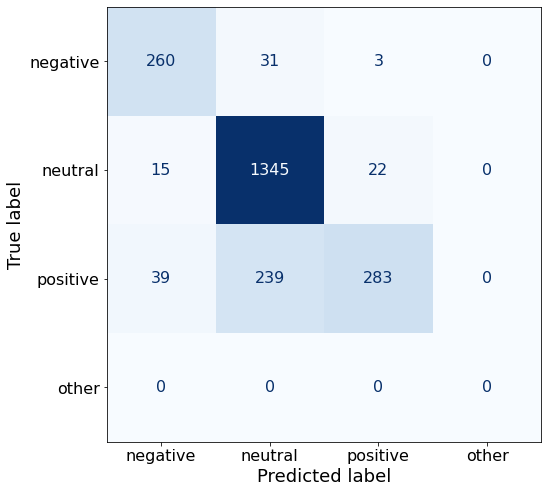

In [45]:
make_cm(df)

In [47]:
df.to_csv('/notebooks/Qwen2-1.5B-Instruct_AI.csv', index=False)

## Running Inference 10 Times Using the Best Prompt

In [53]:
def test_gen(examples):
    few_shot_examples = []
    
    for example in examples:
        few_shot_examples.append({"role": "user", "content": promptA.format(text=example[0])})
        few_shot_examples.append({"role": "assistant", "content": example[1]})
    
    messages = few_shot_examples + [{"role": "user", "content": promptA.format(text=dataset[0]['sentence'])}]
        
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    
    model_inputs = tokenizer([text], return_tensors="pt").to(device)

    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=2
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]

    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].strip().lower()
    return response

In [54]:
%timeit -n 10 test_gen(examples)

208 ms ± 1.93 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [59]:
#| code-fold: true
#| code-summary: "Show updated `few_shot_responses` function"
def few_shot_responses(dataset, prompt, examples):
    responses = []
    dataset = dataset.map(add_prompt, fn_kwargs={"prompt": prompt})
    
    few_shot_examples = []
    
    for example in examples:
        few_shot_examples.append({"role": "user", "content": prompt.format(text=example[0])})
        few_shot_examples.append({"role": "assistant", "content": example[1]})
    
    for row in dataset:
        messages = few_shot_examples + [{"role": "user", "content": row['prompt']}]
        
        text = tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        model_inputs = tokenizer([text], return_tensors="pt").to(device)

        generated_ids = model.generate(
            model_inputs.input_ids,
            max_new_tokens=2
        )
        generated_ids = [
            output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
        ]

        response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].strip().lower()
        responses.append(response)
        
    # calculate accuracy
    df = dataset.to_pandas()
    df['responses'] = pd.Series(responses)
    df['responses'] = df['responses'].apply(lambda x: x if x in ['negative', 'positive', 'neutral'] else "other")
    df['lm_match'] = df['label_text'] == df['responses']
    acc = df.lm_match.mean()
    
    return df, acc

In [60]:
len(examples)

27

In [62]:
exclude_idxs[:10]

[293, 266, 264, 6, 347, 7, 263, 9, 38, 37]

In [ ]:
accs = []
for _ in range(10):
    df, acc = few_shot_responses(promptAD_ds, promptA, examples)
    accs.append(acc)

This prompt results in a pretty consistent overall accuracy, around 86%.

In [64]:
pd.Series(accs).describe()

count    10.000000
mean      0.859321
std       0.004617
min       0.847564
25%       0.858739
50%       0.860304
75%       0.861310
max       0.865445
dtype: float64

## Final Thoughts

Here are the results from my experiments so far (\**the best-performing prompt from this notebook):

|Model|Prompting Strategy|Overall Accuracy|`negative`|`neutral`|`positive`|
|:-:|:-:|:-:|:-:|:-:|:-:|
|claude-3-5-sonnet-20240620|3-Shot|94.78%|98% (297/303) | 94% (1302/1391)|95% (544/570)|
|claude-3-opus-20240229|0-Shot|94.13%|98% (297/303)|96% (1333/1391)|88% (501/570)|
|phi-3.5|20-Shot|93.94%|96% (286/299)|98% (1355/1379)|83% (467/566)|
|phi-3|30-Shot w/System Prompt|92.79%|98% (290/297)|94% (1284/1373)|88% (499/564)|
|claude-3-haiku-20240307|3-Shot|92.39%|90% (272/303)|91% (1267/1391)|96% (550/570)|
|phi-2|6-Shot|91.94%|88% (267/302)|94% (1299/1387)|90% (510/569)|
|\**Qwen2-1.5B|27-Shot|81.60%|90% (264/294)|95.5% (1320/1382)|61% (342/561)|


Here are the results from this notebook. 
The best-performing prompt was a randomly shuffled 27-Shot prompt ([Prompt AD](#prompt-ad)), yielding an overall accuracy of 86.10%.

|prompt|strategy|accuracy|negative|neutral|positive|
|:-:|:-:|:-:|:-:|:-:|:-:|
|[A](#prompt-a)|0-Shot|81.76%|97% (293/303)|85% (1185/1391)|65% (373/570)|
|[B](#prompt-b)|0-Shot|51.86%|99% (300/303)|61% (846/1391)|5% (28/570)|
|[C](#prompt-c)|0-Shot|81.40%|93% (283/303)|96% (1330/1391)|40% (230/570)|
|[D](#prompt-d)|0-Shot|78.53%|92% (279/303)|92% (1281/1391)|38% (218/570)|
|[E](#prompt-e)|0-Shot|66.21%|<u>**100% (302/303)**</u>|82% (1145/1391)|9% (52/570)|
|[F](#prompt-f)|0-Shot|78.05%|88% (267/303)|97% (1355/1391)|25% (145/570)|
|[G](#prompt-g)|0-Shot|66.70%|94% (285/303)|80% (1107/1391)|21% (118/570)|
|[H](#prompt-h)|0-Shot|70.89%|85% (259/303)|90% (1247/1391)|17% (99/570)|
|[I](#prompt-i)|0-Shot|69.17%|58% (176/303)|86% (1201/1391)|33% (189/570)|
|[J](#prompt-j)|0-Shot|57.38%|47% (142/303)|78% (1086/1391)|12% (71/570)|
|[K](#prompt-k)|0-Shot|41.87%|34% (102/303)|52% (728/1391)|21% (118/570)|
|[L](#prompt-l)|0-Shot|42.84%|66% (200/303)|45% (629/1391)|25% (141/570)|
|[M](#prompt-m)|0-Shot|51.46%|26% (79/303)|77% (1078/1391)|1% (8/570)|
|[N](#prompt-n)|0-Shot|29.77%|11% (33/303)|44% (608/1391)|6% (33/570)|
|[O](#prompt-o)|0-Shot|61.00%|37% (113/303)|90% (1257/1391)|2% (11/570)|
|[P](#prompt-p)|3-Shot|78.20%|91% (275/302)|91% (1266/1390)|40% (227/569)|
|[Q](#prompt-q)|6-Shot|76.93%|96% (289/302)|73% (1010/1387)|<u>**77% (438/569)**</u>|
|[R](#prompt-r)|20-Shot|81.42%|92% (274/299)|94% (1301/1379)|45% (252/566)|
|[S](#prompt-s)|30-Shot|81.51%|87% (255/294)|98% (1345/1379)|39% (221/561)|
|[T](#prompt-t)|27-Shot|83.73%|93% (272/294)|94.3% (1303/1382)|53% (298/561)|
|[U](#prompt-u)|25-Shot|82.94%|90% (266/294)|96.2% (1331/1384)|46% (260/561)|
|[V](#prompt-v)|21-Shot|83.28%|92% (273/296)|94.9% (1314/1384)|50% (281/563)|
|[W](#prompt-w)|15-Shot|81.55%|94% (279/298)|87.7% (1215/1386)|60% (340/565)|
|[X](#prompt-x)|30-Shot|81.74%|89% (261/293)|96.7% (1336/1381)|41% (229/560)|
|[Y](#prompt-y)|60-Shot|75.82%|66% (186/283)|<u>**99.8% (1368/1371)**</u>|21% (117/550)|
|[Z](#prompt-z)|27-Shot|81.36%|80% (236/294)|99.4% (1374/1382)|37% (210/561)|
|[AA](#prompt-aa)|23-Shot|82.95%|93% (276/296)|94.9% (1314/1384)|48% (269/561)|
|[AB](#prompt-ab)|25-Shot|83.70%|92% (270/294)|95.3% (1317/1382)|51% (287/563)|
|[AC](#prompt-ac)|23-Shot|83.40%|95% (278/294)|93.8% (1296/1382)|52% (295/565)|
|[AD](#prompt-ad)|27-Shot|<u>**86.10%**</u>|90% (264/294)|95.5% (1320/1382)|61% (342/561)|
|[AE](#prompt-ae)|60-Shot|83.71%|83% (234/283)|97.8% (1341/1371)|49% (270/550)|
|[AF](#prompt-af)|15-Shot|82.00%|91% (272/298)|88.8% (1231/1386)|60% (341/565)|
|[AG](#prompt-ag)|27-Shot w/System Prompt|84.40%|84% (248/294)|97.8% (1351/1382)|52% (289/561)|
|[AH](#prompt-ah)|27-Shot w/System Prompt|84.67%|87% (256/294)|97.1% (1342/1382)|53% (296/561)|
|[AI](#prompt-ai)|27-Shot w/System Prompt|84.99%|88% (260/294)|97.3% (1345/1382)|50% (283/561)|


Here are my takeaways from working with Qwen2-1.5B-Instruct:

- **It was easy to get a decent overall accuracy (on my first try!) but quite difficult to improve upon it.** 
Although I tested out 35 prompts, there's still much more room for experimentation.
- **The `positive` sentiment True Positive Rate was considerably worse than `neutral` or `negative` sentiments.** 
The most accurate `positive` sentiment classification was 77% (Prompt Q) compared to 99.8% for `negative` (Prompt Y) 
and 100% for `neutral` (Prompt E).
- **Randomizing the order of the examples improved my 27-Shot prompt's overall accuracy.** I had not tried this before and is something I'll make 
sure to use again in the future.
- **The best-performing prompt contained an equal number of examples from each sentiment (9 per sentiment).** Decreasing the 
representation of each sentiment worsened the overall accuracy.
- **The best performing prompt for each sentiment is not the best overall prompt.** This is important to note because there may be
situations where one type of sentiment is more critical than the other. For example, it may be "safer" to have a high TPR for 
`negative` or `positive` sentiment if people are making decisions based on the predicted sentiment.

I hope you enjoyed this blog post! Follow me on Twitter [@vishal_learner](https://twitter.com/vishal_learner).